# Ciencia de Datos. TP2: Series Temporales

Axel Maddonni, LU 200/14 <br>
Federico Patane, LU 683/10<br>


*Septiembre 2017*

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sps
import scipy.io as sio
%matplotlib inline
matplotlib.style.use('ggplot')

## Cargado de los datos

Utilizando funciones de pandas, cargamos los datos de EEG de cada paciente en un dataframe.

In [2]:
def convertToDataFrame(data):
    epochs, electrodos, tiempos =  data.shape
    data = data.reshape((electrodos*epochs, tiempos))

    l1 = []
    l2 = []
    datos = []
    for x in range(0, electrodos) : 
        for y in range(0, epochs) : 
            l1.append(x)
            l2.append(y)

    l =  [l1,l2]
    tuples = list(zip(*l))

    index = pd.MultiIndex.from_tuples(tuples, names=['electrodos', 'epochs'])

    return pd.DataFrame(data, index=index)

def dataEpochs(df):
    return df.shape[0] / electrodos

In [3]:
electrodos, tiempos =  256, 201

In [4]:
dfs = [
    convertToDataFrame(sio.loadmat('P01.mat')['data']),
    convertToDataFrame(sio.loadmat('P02.mat')['data']),
    convertToDataFrame(sio.loadmat('P03.mat')['data']),
    convertToDataFrame(sio.loadmat('P04.mat')['data']),
    convertToDataFrame(sio.loadmat('P05.mat')['data']),
    convertToDataFrame(sio.loadmat('P06.mat')['data']),
    convertToDataFrame(sio.loadmat('P07.mat')['data']),
    convertToDataFrame(sio.loadmat('P08.mat')['data']),
    convertToDataFrame(sio.loadmat('P09.mat')['data']),
    convertToDataFrame(sio.loadmat('P10.mat')['data']),
    convertToDataFrame(sio.loadmat('S01.mat')['data']),
    convertToDataFrame(sio.loadmat('S02.mat')['data']),
    convertToDataFrame(sio.loadmat('S03.mat')['data']),
    convertToDataFrame(sio.loadmat('S04.mat')['data']),
    convertToDataFrame(sio.loadmat('S05.mat')['data']),
    convertToDataFrame(sio.loadmat('S06.mat')['data']),
    convertToDataFrame(sio.loadmat('S07.mat')['data']),
    convertToDataFrame(sio.loadmat('S08.mat')['data']),
    convertToDataFrame(sio.loadmat('S09.mat')['data']),
    convertToDataFrame(sio.loadmat('S10.mat')['data']) ]

## Ejercicio 1.a.1)

Cálculo y gráfico de la potencia en función de epochs y frecuencia, promediada entre los los valores obtenidos por cada paciente.

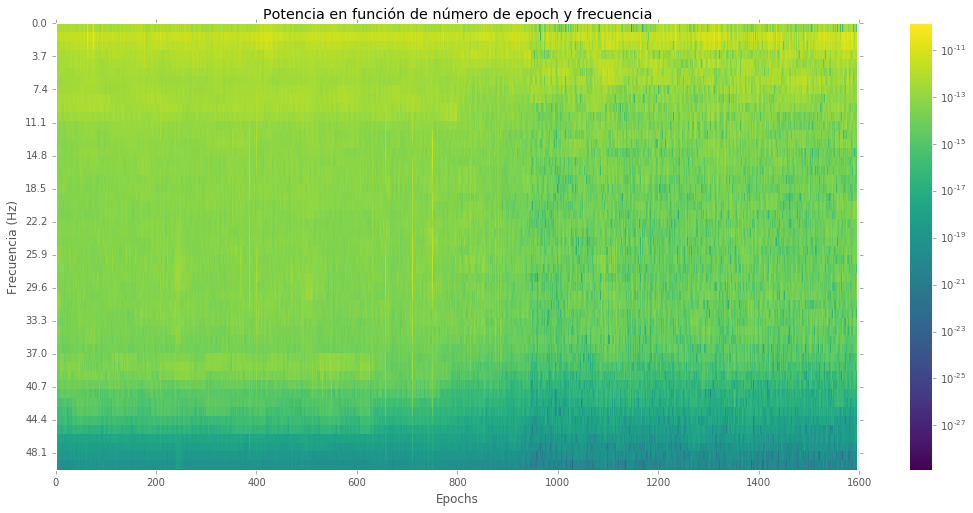

In [5]:
from matplotlib.colors import LogNorm

potencias = []
maxEpochs = 0
for data in dfs :
    df_concat = pd.DataFrame([])
    for x in (8,44,80,131,185):
        df = data.loc[x]
        df_concat = pd.concat((df_concat, df))
    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean()
    heatmapData = []
    for e in range(0, dataEpochs(data)):
        f, Pxx_den = sps.welch(df_means.loc[e], fs=250, nperseg=201)
        heatmapData.append(Pxx_den)
    heatmapData = np.asarray(heatmapData)
    heatmapData = np.transpose(heatmapData)
    if dataEpochs(data) > maxEpochs :
        maxEpochs = dataEpochs(data)
    maxFrecuencia = f.shape[0]
    potencias.append(heatmapData)

meanHeatmapData = np.empty([maxFrecuencia, maxEpochs])
for f in range(0, maxFrecuencia, 1) :
    for e in range (0, maxEpochs, 1) :
        p = 0
        c = 0
        for heatmapData in potencias :
            if heatmapData.shape[1] > e :
                p += heatmapData[f][e]
                c = c + 1
        meanHeatmapData[f][e] = p / c

X = np.arange(0, maxEpochs, 1)
Y = np.arange(0, maxFrecuencia, 1)
X, Y = np.meshgrid(X, Y)

plt.figure(figsize=(18, 8))
plt.ylim([0,50])
plt.yticks(np.arange(0, 50, 3.7))
plt.pcolormesh(X, Y, meanHeatmapData, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.title(("Potencia en función de número de epoch y frecuencia").decode('utf-8'))
plt.xlabel('Epochs')
plt.ylabel('Frecuencia (Hz)')
plt.gca().invert_yaxis()
plt.show()

## Ejercicio 1.a.2)

Cálculo y gráfico de la potencia media obtenida por frecuencia, promediada entre los datos de todos los sujetos.

/home/axel/.local/lib/python2.7/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 251, is greater than input length = 201, using nperseg = 201
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


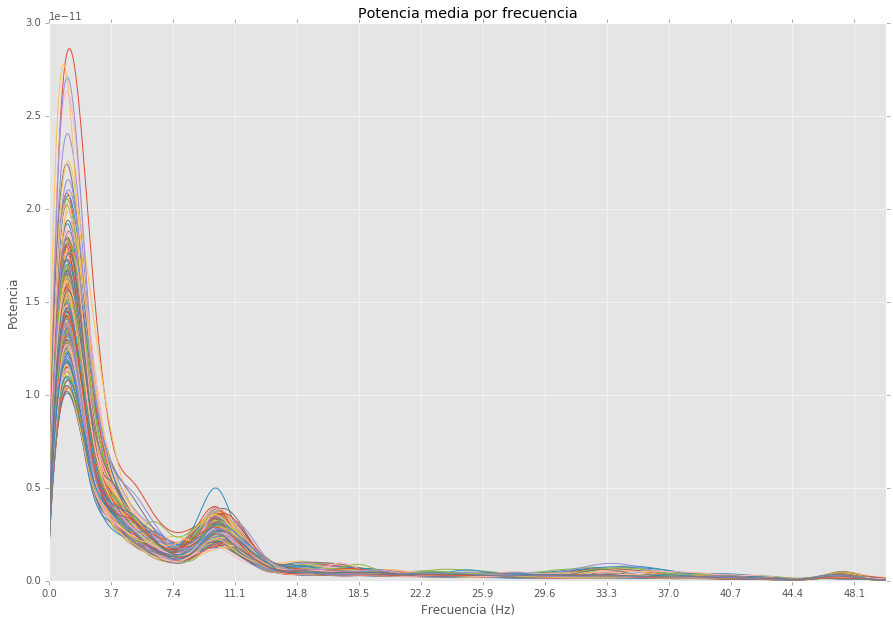

In [6]:
from scipy.interpolate import interp1d

plt.figure(figsize=(15, 10))
plt.xlim([0,50])
plt.xticks(np.arange(0, 50, 3.7))

for e in range(0, electrodos):
    meanDensities = []
    for data in dfs :
        densities = []
        for i in range(0, dataEpochs(data)):
            f, Pxx_den = sps.welch(data.loc[e,i], fs=250, nperseg=251)
            densities.append(Pxx_den)
        f = np.asarray(f)
        densities = np.asarray(densities)
        meanDensities.append(densities.mean(axis=0))
    meanDensities = np.asarray(meanDensities).mean(axis=0)
    func = interp1d(f, meanDensities, kind='cubic')
    fnew = np.linspace(0, 50, num=1000, endpoint=True)
    plt.plot(fnew, func(fnew))

plt.title(("Potencia media por frecuencia").decode('utf-8'))
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia')
plt.show()

## Ejercicio 1.b)

Cálculo del poder espectral de cada banda de frecuencia para cada paciente. Los resultados se muestran en un gráfico de barra por paciente.

/home/axel/.local/lib/python2.7/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 201, using nperseg = 201
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


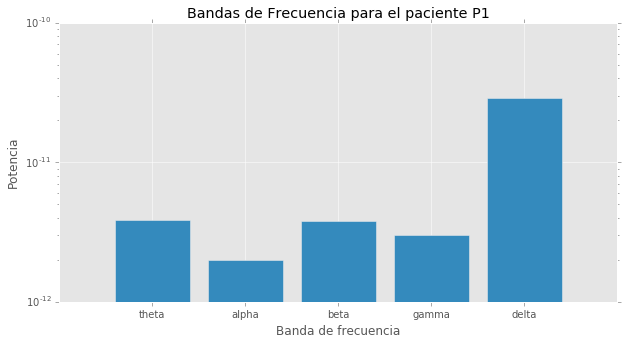

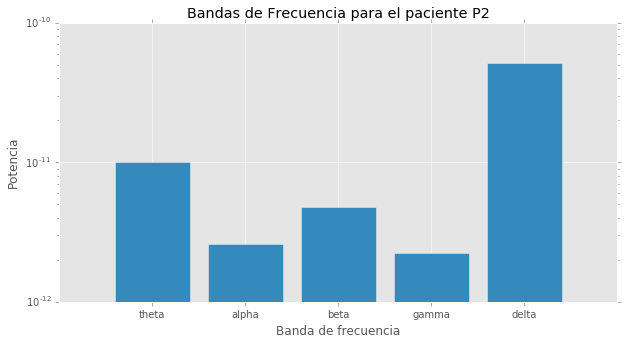

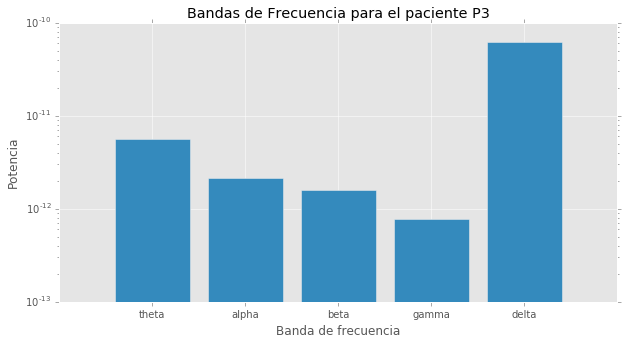

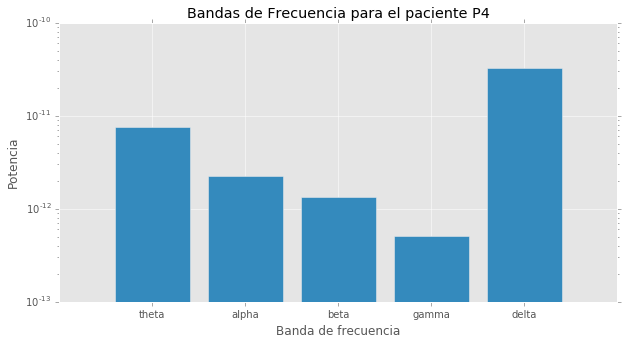

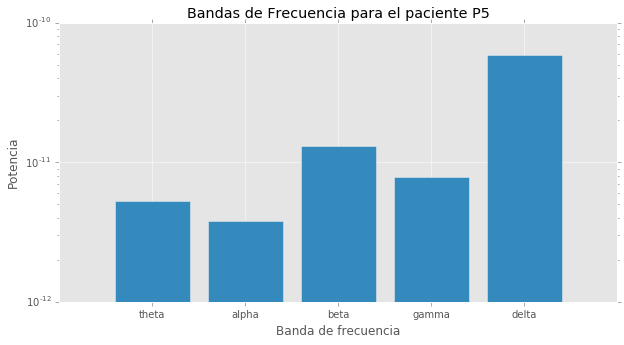

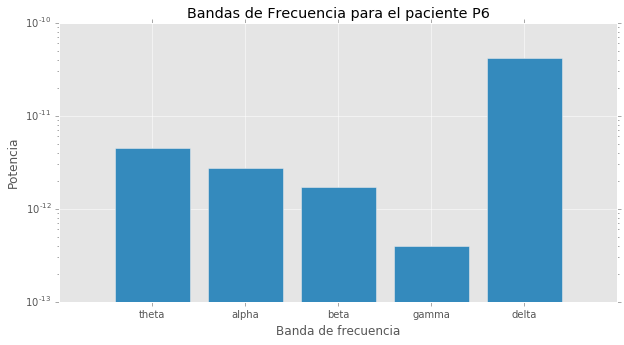

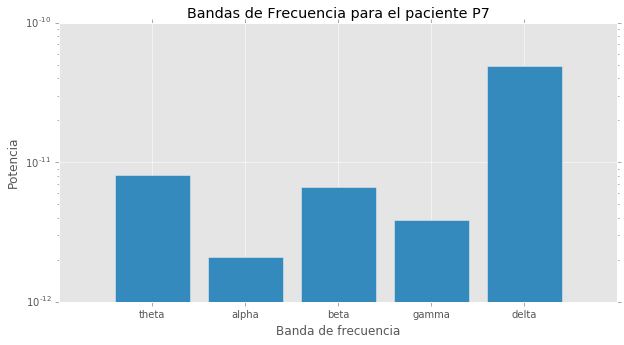

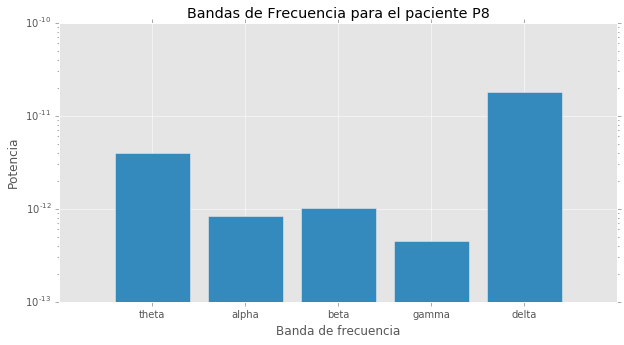

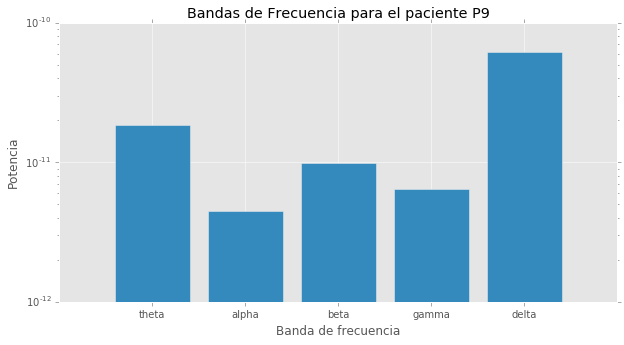

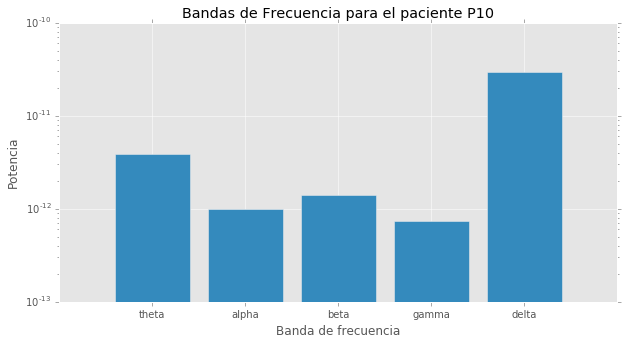

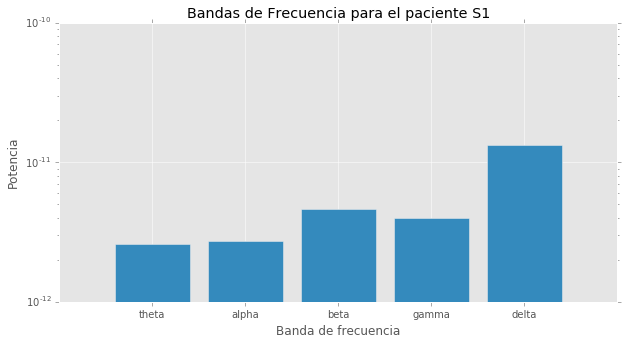

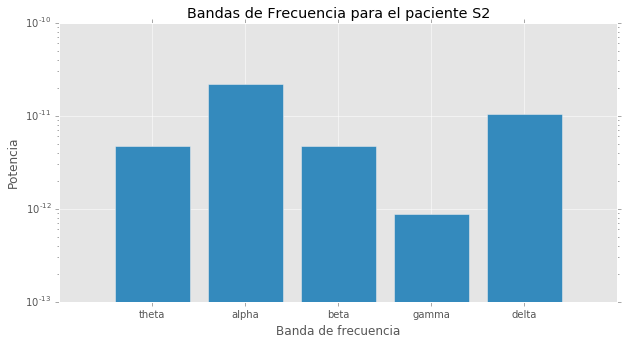

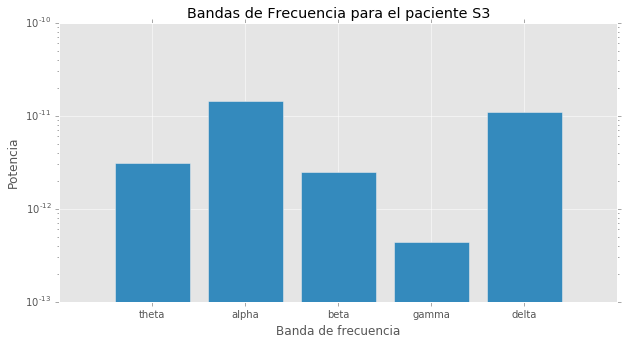

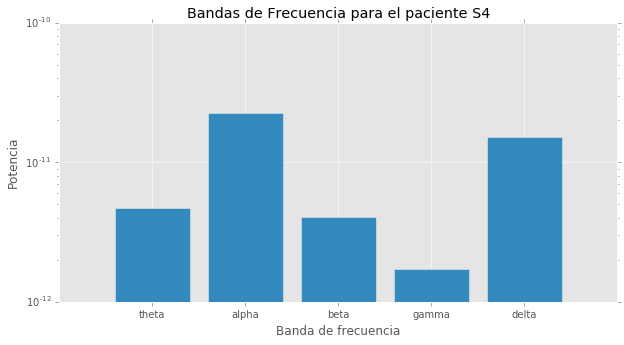

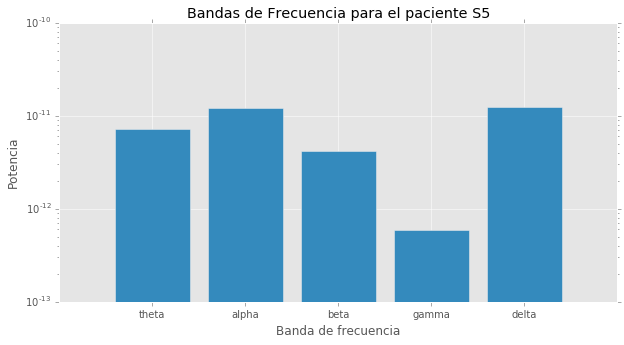

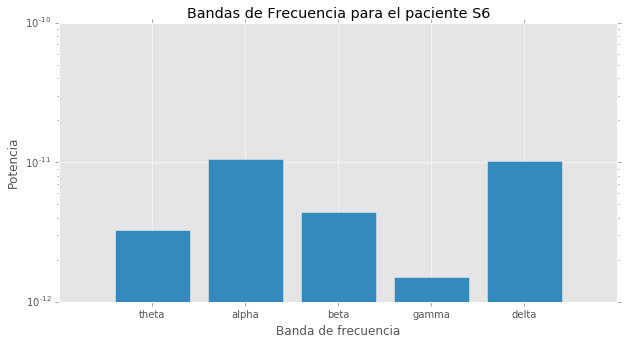

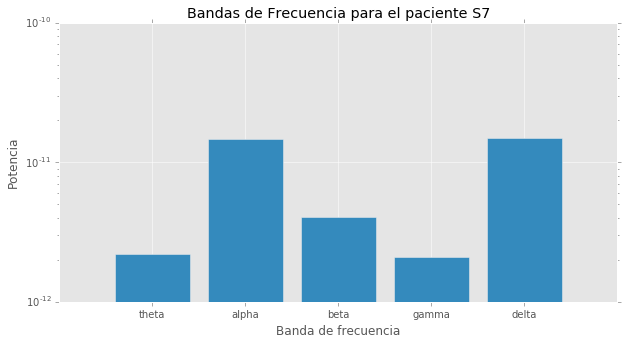

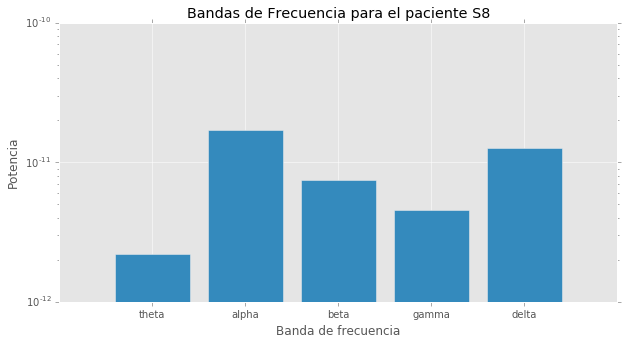

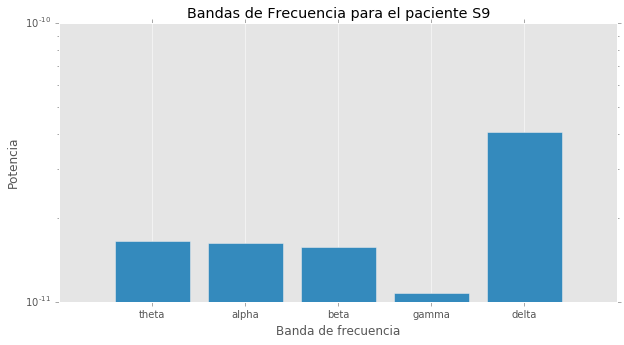

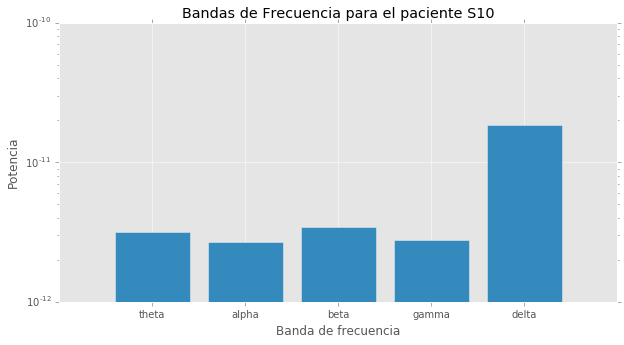

In [7]:
def get_espectro(frecuencia, potencia):
    delta, theta, alpha, beta, gamma = 0, 0, 0, 0, 0
    i = 0
    while i < len(frecuencia) : 
        if frecuencia[i] < 4 : 
            delta += potencia[i]
        else : 
            if frecuencia[i] >= 4 and frecuencia[i] < 8 :
                theta += potencia[i]
            else : 
                if frecuencia[i] >= 8 and frecuencia[i] < 13 :
                    alpha += potencia[i]
                else : 
                    if frecuencia[i] >= 13 and frecuencia[i] < 30 :
                        beta += potencia[i]
                    else : 
                        gamma += potencia[i]
        i = i + 1
    return delta , theta , alpha , beta , gamma

def calcularBandasDeFrecuencia(data, paciente):
    deltaProm , thetaProm , alphaProm , betaProm , gammaProm = [], [], [], [], []
    bandas = []
    for e in range(0, electrodos):
        for i in range(0, dataEpochs(data)):
            f, Pxx_den = sps.welch(data.loc[e,i], fs=250)
            delta , theta , alpha , beta , gamma = get_espectro(f , Pxx_den)
            bandas.append(np.asarray([delta, theta, alpha, beta, gamma]))
    bandas = np.asarray(bandas).mean(axis=0)
    graficarBandas(bandas, paciente)
    return bandas

def graficarBandas(bandas, paciente):
    D = {'delta': bandas[0], 'theta': bandas[1], 'alpha': bandas[2], 'beta': bandas[3], 'gamma': bandas[4] }
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(D)), D.values(), align='center')
    plt.xticks(range(len(D)), D.keys())
    plt.yscale('log')
    plt.title('Bandas de Frecuencia para el paciente ' + paciente)
    plt.xlabel('Banda de frecuencia')
    plt.ylabel('Potencia')
    plt.show()

n = 1
bandasFrecuencia = []
for data in dfs :
    if n < 11 :
        paciente = 'P' + str(n)
    else :
        paciente = 'S' + str(n-10)
    potencias = calcularBandasDeFrecuencia(data, paciente)
    bandasFrecuencia.append(potencias)
    n = n + 1

bandasFrecuencia = np.asarray(bandasFrecuencia)

In [8]:
# Otras maneras de calcular las bandas de frecuencia (distintas maneras de tomar los promedios)

# Calculando un solo welch promediando todos los epoch de un sujeto
def calcularBandasDeFrecuencia1(a):
    promedio = a.mean()
    frecuencia , potencia = sps.welch(promedio, fs = 250)
    delta , theta , alpha , beta , gamma = get_espectro(frecuencia , potencia)
    D = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma }
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(D)), D.values(), align='center')
    plt.xticks(range(len(D)), D.keys())
    plt.yscale('log')
    plt.show()

# Calculo un welch por electrodo tomando el promedio de todos los epochs, y luego promedio las potencias
def calcularBandasDeFrecuencia2(a):
    densities = []
    for e in range(0, electrodos):
        f, Pxx_den = sps.welch(a.loc[e].mean(), fs=250)
        densities.append(Pxx_den)
    f = np.asarray(f)
    densities = np.asarray(densities)
    densities = densities.mean(axis=0)
    frecuencia , potencia = f, densities
    delta , theta , alpha , beta , gamma = get_espectro(frecuencia , potencia)
    D = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma }
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(D)), D.values(), align='center')
    plt.xticks(range(len(D)), D.keys())
    plt.yscale('log')
    plt.show()

# Calculo un welch por electrodo y epoch y tomo el promedio de las potencias
def calcularBandasDeFrecuencia3(a):
    densities = []
    for e in range(0, electrodos):
        for i in range(0, epochs):
            f, Pxx_den = sps.welch(a.loc[e,i], fs=250)
            densities.append(Pxx_den)
    f = np.asarray(f)
    densities = np.asarray(densities)
    densities = densities.mean(axis=0)
    frecuencia , potencia = f, densities
    delta , theta , alpha , beta , gamma = get_espectro(frecuencia , potencia)
    D = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma }
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(D)), D.values(), align='center')
    plt.xticks(range(len(D)), D.keys())
    plt.yscale('log')
    plt.show()

## Ejercicio 1.c)

Comparación de valores obtenidos en la banda alpha para los distintos tipos de paciente: con capacidades cognitivas normales (Pacientes S), y con capacidades cognitivas severamente disminuidas (Pacientes P), usando distintos gráficos de seaborn.

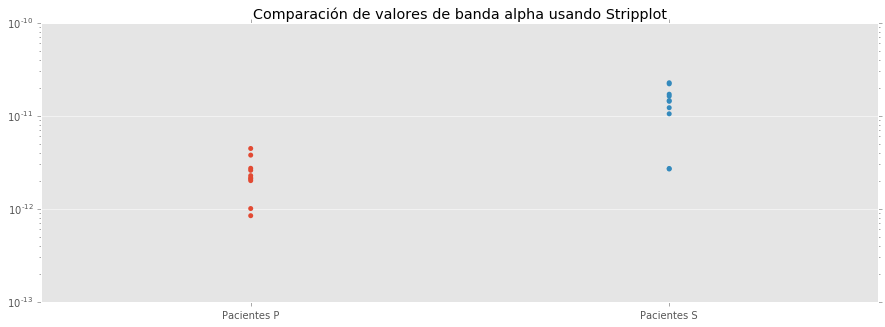

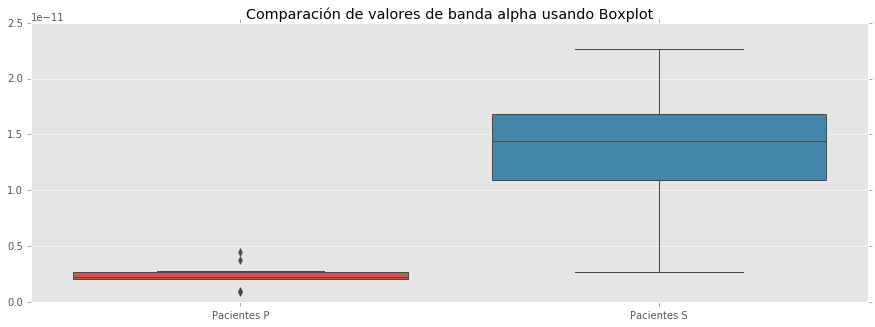

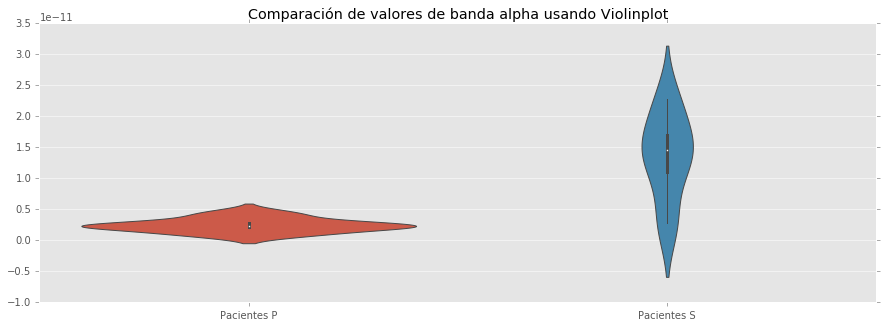

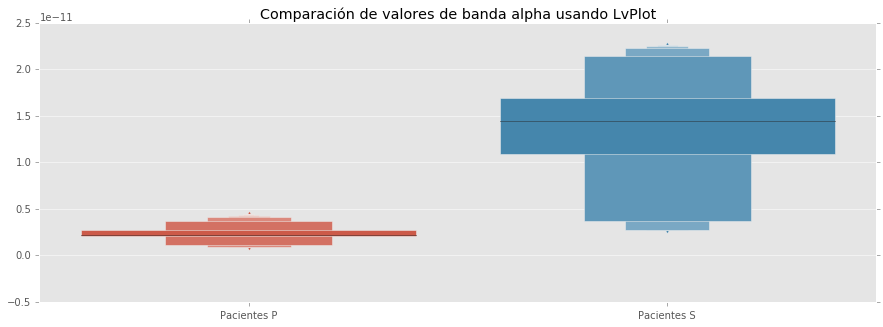

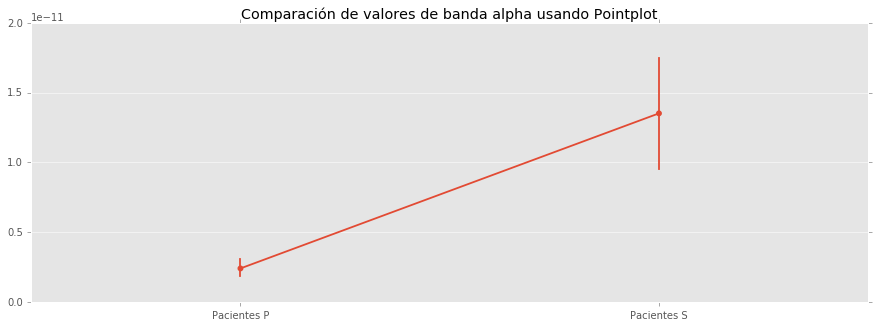

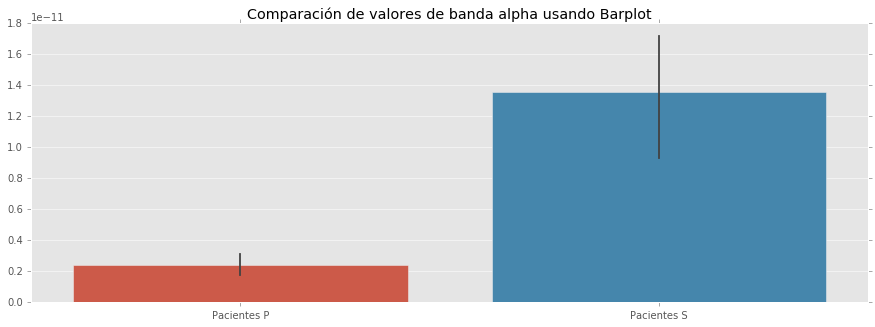

In [9]:
def compararBanda(dataset):
    plt.figure(figsize=(15, 5))
    plt.title(("Comparación de valores de banda alpha usando Stripplot").decode('utf-8'))
    plt.yscale('log')
    sns.stripplot(data=dataset)
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.title(("Comparación de valores de banda alpha usando Boxplot").decode('utf-8'))
    sns.boxplot(data=dataset)
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.title(("Comparación de valores de banda alpha usando Violinplot").decode('utf-8'))
    sns.violinplot(data=dataset)
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.title(("Comparación de valores de banda alpha usando LvPlot").decode('utf-8'))
    sns.lvplot(data=dataset)
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.title(("Comparación de valores de banda alpha usando Pointplot").decode('utf-8'))
    sns.pointplot(data=dataset)
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.title(("Comparación de valores de banda alpha usando Barplot").decode('utf-8'))
    sns.barplot(data=dataset)
    plt.show()

alphas = pd.DataFrame([])
alphas['Pacientes P'] = bandasFrecuencia[0:10,2]
alphas['Pacientes S'] = bandasFrecuencia[10:20,2]

compararBanda(alphas)

## Ejercicio 1.d)

Comparación de valores obtenidos en cada banda para los distintos tipos de paciente: con capacidades cognitivas normales (Pacientes S), y con capacidades cognitivas severamente disminuidas (Pacientes P), usando letter-value plot.

Decidimos utilizar *letter-value plots* ya que consiste de un método rápido, no paramétrico e intuitivo para estimar la distribución de los datos. Generan gráficos con más información sobre la distribución (en particular, sobre las colas de la distribución) que utilizando boxplots.

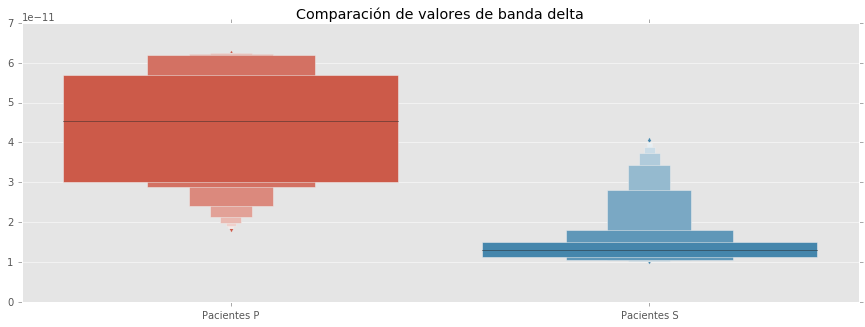

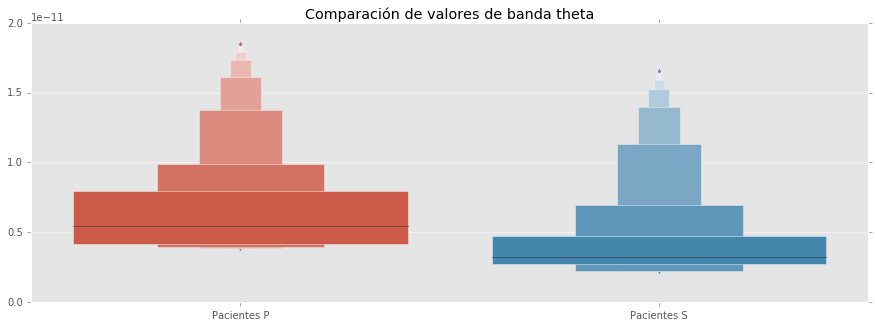

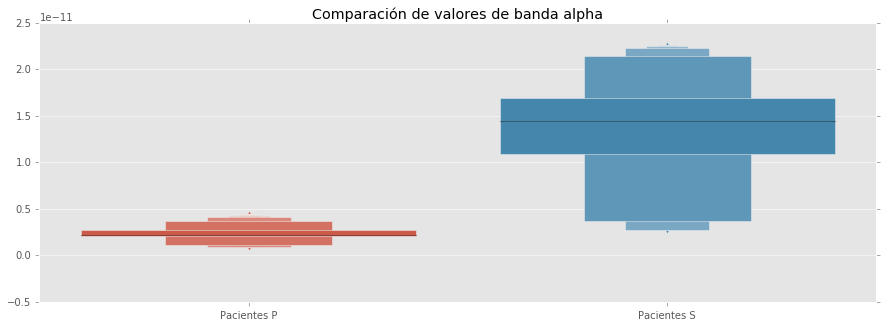

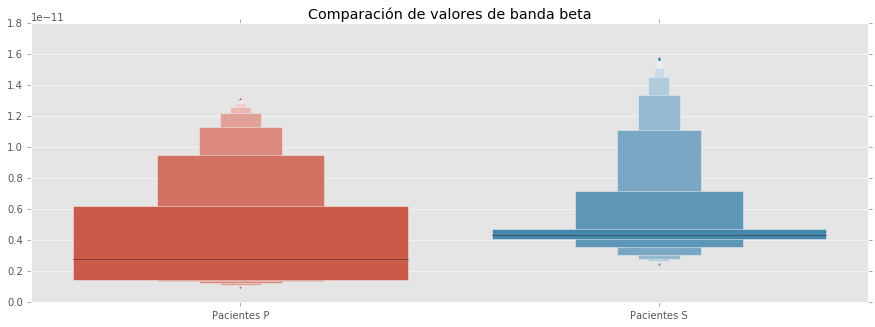

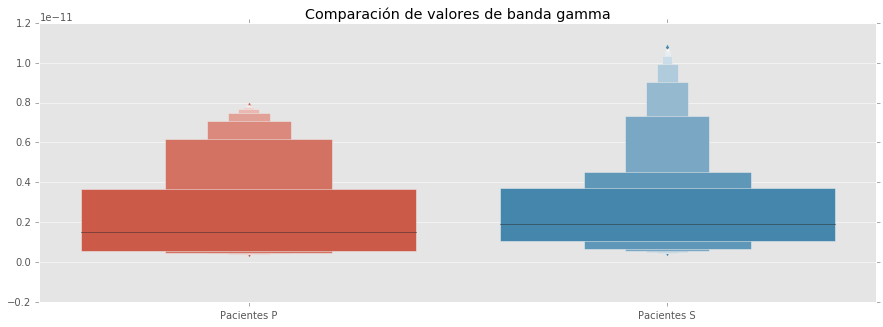

In [10]:
def compararBandasConLvPlot(dataset, nombre):
    plt.figure(figsize=(15, 5))
    plt.title(("Comparación de valores de banda " + nombre).decode('utf-8'))
    sns.lvplot(data=dataset)
    plt.show()

deltas = pd.DataFrame([])
deltas['Pacientes P'] = bandasFrecuencia[0:10,0]
deltas['Pacientes S'] = bandasFrecuencia[10:20,0]
compararBandasConLvPlot(deltas, 'delta')

thetas = pd.DataFrame([])
thetas['Pacientes P'] = bandasFrecuencia[0:10,1]
thetas['Pacientes S'] = bandasFrecuencia[10:20,1]
compararBandasConLvPlot(thetas, 'theta')

alphas = pd.DataFrame([])
alphas['Pacientes P'] = bandasFrecuencia[0:10,2]
alphas['Pacientes S'] = bandasFrecuencia[10:20,2]
compararBandasConLvPlot(alphas, 'alpha')

betas = pd.DataFrame([])
betas['Pacientes P'] = bandasFrecuencia[0:10,3]
betas['Pacientes S'] = bandasFrecuencia[10:20,3]
compararBandasConLvPlot(betas, 'beta')

gammas = pd.DataFrame([])
gammas['Pacientes P'] = bandasFrecuencia[0:10,4]
gammas['Pacientes S'] = bandasFrecuencia[10:20,4]
compararBandasConLvPlot(gammas, 'gamma')

### Test estadístico sobre poder espectral de la banda alpha

Observando los gráficos, podemos notar en principio que los pacientes en estado normal (Grupo S) muestran un poder espectral de la banda alpha superior a la de los pacientes del grupo P. 

Plantearemos un test no-paramétrico para intentar refutar la siguiente hipótesis nula:

H0: La media de los valores para la banda alpha para pacientes S y P es la misma.
Más específicamente, usaremos un test de una cola para comprobar que la media de los valores correspondientes a los pacientes del Grupo S es mayor a la correspondiente a los del grupo P.


In [11]:
import scipy.stats as sp

rd1 = np.copy(alphas.iloc[:,0])
rd2 = np.copy(alphas.iloc[:,1])
np.random.shuffle(rd1)
np.random.shuffle(rd2)
f = sp.mannwhitneyu(rd1, rd2, alternative='less')

print 'P-valor: %.10f' % f[1]

P-valor: 0.0005039881


Como esperábamos, el pvalor obtenido por el test es un número menor al nivel de significancia (0.05), por lo que podemos rechazar la hipótesis nula, y afirmar basándonos en nuestros datos, que hay altas probabilidades de que el poder espectral de la banda alpha, obtenido a partir de las muestras de EEG analizadas, en pacientes con capacidades cognitivas normales (Pacientes S) es mayor al de los pacientes con capacidades cognitivas severamente disminuidas (Pacientes P).

## Ejercicio 1.e)

Realizamos nuevamente la comparación de los resultados obtenidos sobre el poder espectral de las bandas, esta vez utilizando los valores normalizados.

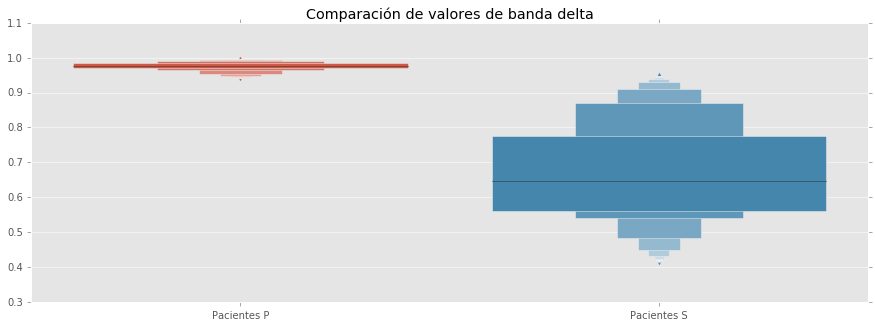

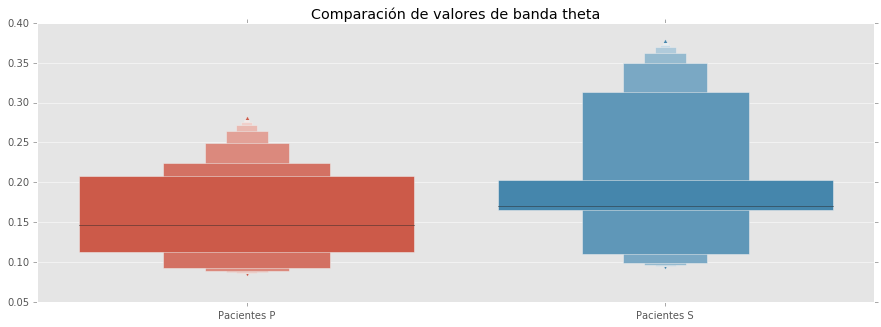

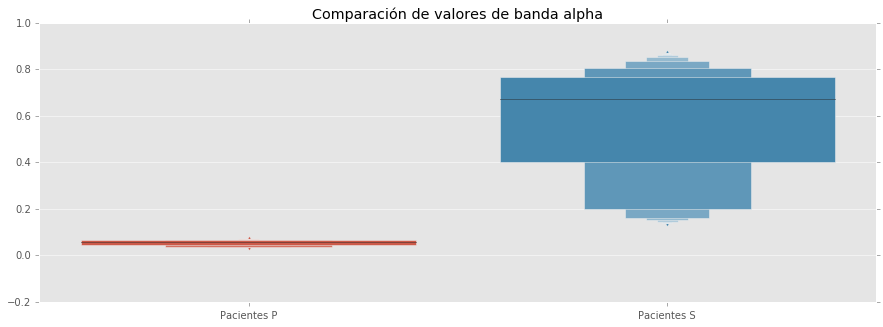

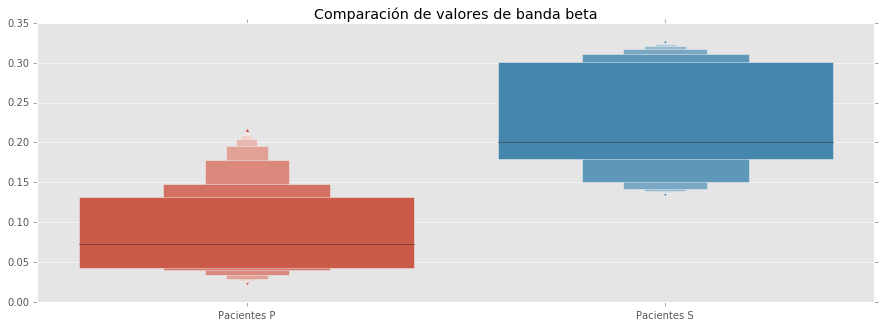

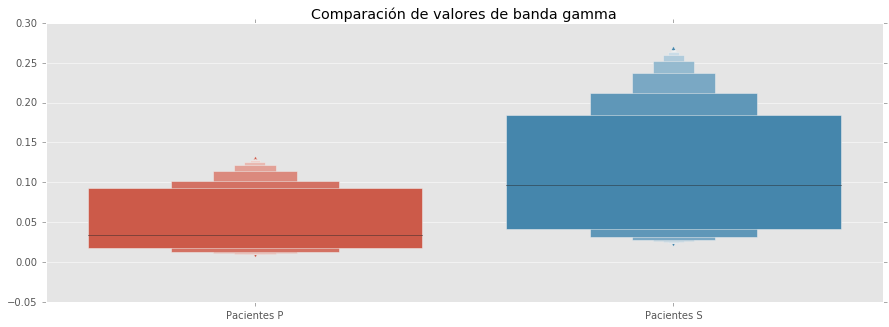

In [12]:
from sklearn import preprocessing
bandasFrecuencia_normalized = preprocessing.normalize(bandasFrecuencia)

deltasNorm = pd.DataFrame([])
deltasNorm['Pacientes P'] = bandasFrecuencia_normalized[0:10,0]
deltasNorm['Pacientes S'] = bandasFrecuencia_normalized[10:20,0]
compararBandasConLvPlot(deltasNorm, 'delta')

thetasNorm = pd.DataFrame([])
thetasNorm['Pacientes P'] = bandasFrecuencia_normalized[0:10,1]
thetasNorm['Pacientes S'] = bandasFrecuencia_normalized[10:20,1]
compararBandasConLvPlot(thetasNorm, 'theta')

alphasNorm = pd.DataFrame([])
alphasNorm['Pacientes P'] = bandasFrecuencia_normalized[0:10,2]
alphasNorm['Pacientes S'] = bandasFrecuencia_normalized[10:20,2]
compararBandasConLvPlot(alphasNorm, 'alpha')

betasNorm = pd.DataFrame([])
betasNorm['Pacientes P'] = bandasFrecuencia_normalized[0:10,3]
betasNorm['Pacientes S'] = bandasFrecuencia_normalized[10:20,3]
compararBandasConLvPlot(betasNorm, 'beta')

gammasNorm = pd.DataFrame([])
gammasNorm['Pacientes P'] = bandasFrecuencia_normalized[0:10,4]
gammasNorm['Pacientes S'] = bandasFrecuencia_normalized[10:20,4]
compararBandasConLvPlot(gammasNorm, 'gamma')